# Ensemble

In [1]:
import pandas as pd 
import numpy as np 

## Setting Up the Data 

In [2]:
# linear regression
linreg_train_test = pd.read_csv('linreg_20230810_output.csv')
linreg_upcoming = pd.read_csv('linreg_20230810_full_predictions.csv')

# principal component regression 
pcr_train_test = pd.read_csv('pcr_20231008_output.csv')
pcr_upcoming = pd.read_csv('pcr_20231008_full_predictions.csv')

# train_test 
def key_pred_creator(df,model_name):
    df['KEY'] = df['Team']+'_'+df['Season'].astype(str)
    df.columns = ['Actual',model_name+'_predictions','Team','Season','SUBSET','KEY']
    return df 

linreg_train_test = key_pred_creator(linreg_train_test,'linreg')
pcr_train_test = key_pred_creator(pcr_train_test,'pcr')

train_test = pcr_train_test.merge(linreg_train_test[['KEY','linreg_predictions']],how='left',on='KEY')

# upcoming 
linreg_upcoming = linreg_upcoming[['Team','Predicted Wins']].copy()
pcr_upcoming = pcr_upcoming[['Team','Predicted Wins']].copy()

linreg_upcoming.columns = ['Team','linreg_predictions']
pcr_upcoming.columns = ['Team','pcr_predictions']

upcoming = pcr_upcoming.merge(linreg_upcoming,how='left',on='Team')

In [3]:
train_test

,Actual,pcr_predictions,Team,Season,SUBSET,KEY,linreg_predictions
0,0.0,-2.470251,Bulls,2001,TRAIN,Bulls_2001,-2.430140
1,0.0,-1.631518,Grizzlies,2001,TRAIN,Grizzlies_2001,-1.418797
2,0.0,-0.428526,Warriors,2001,TRAIN,Warriors_2001,-1.163000
3,0.0,-0.375637,Wizards,2001,TRAIN,Wizards_2001,0.197333
4,0.0,0.027601,Clippers,2001,TRAIN,Clippers_2001,1.367652
...,...,...,...,...,...,...,...
650,1.0,5.019328,Clippers,2022,TEST,Clippers_2022,4.209794
651,13.0,5.486485,Heat,2022,TEST,Heat_2022,5.920710
652,16.0,5.626976,Nuggets,2022,TEST,Nuggets_2022,5.767553
653,1.0,5.990615,Bucks,2022,TEST,Bucks_2022,6.582062


In [4]:
upcoming

,Team,pcr_predictions,linreg_predictions
0,Spurs,-0.774965,-1.208438
1,Hornets,-0.391448,-1.350558
2,Thunder,-0.319234,-0.834752
3,Pistons,-0.142186,-0.576791
4,Rockets,0.074682,-1.743173
5,Trail Blazers,0.593366,0.023129
6,Pacers,0.775188,0.416069
7,Wizards,1.053691,0.949770
8,Raptors,1.323077,1.546322
9,Nuggets,1.483130,6.536247


In [5]:
train = train_test[train_test['SUBSET']=='TRAIN'].copy()
test = train_test[train_test['SUBSET']=='TEST'].copy()
x_train = train.drop(['Actual','Team','Season','KEY','SUBSET'],axis=1)
y_train = train['Actual']
x_test = test.drop(['Actual','Team','Season','KEY','SUBSET'],axis=1)
y_test = test['Actual']

In [6]:
x_train

,pcr_predictions,linreg_predictions
0,-2.470251,-2.430140
1,-1.631518,-1.418797
2,-0.428526,-1.163000
3,-0.375637,0.197333
4,0.027601,1.367652
...,...,...
620,5.090668,5.512650
621,5.144881,5.618615
622,5.337362,6.911727
623,5.917072,6.315585


## Modeling

In [7]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for feature reduction 
from sklearn import feature_selection
from sklearn import pipeline

# for the modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import sklearn

# getting rid of the warnings 
import warnings
warnings.filterwarnings('ignore')

In [8]:
linreg = LinearRegression()

In [9]:
param_grid = {
                'fit_intercept': [True,False]
            }

clf = GridSearchCV(linreg, 
                           param_grid, 
                           scoring='neg_root_mean_squared_error', 
                           cv = 5,
                           return_train_score=True,
                           verbose = 10, 
                           n_jobs = -1
                  )

In [10]:
# Fitting the model 
clf.fit(x_train,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Best Score :",clf.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Tuned Hyperparameters : {'fit_intercept': False}
Best Score : -3.6593924282404453


In [11]:
# storing the CV results 
cv = pd.DataFrame(clf.cv_results_)

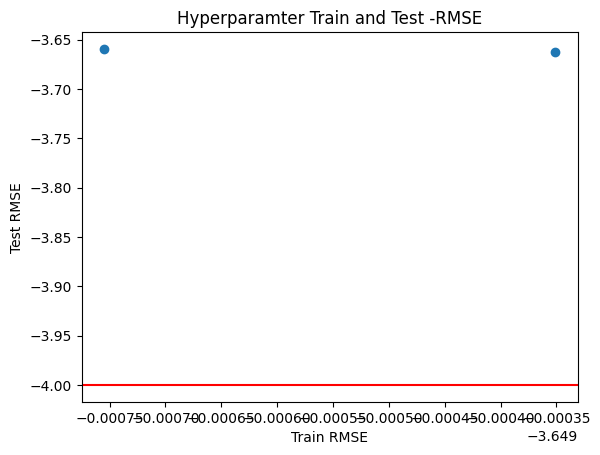

In [12]:
#Plotting the test and train gini to select best parameter
import matplotlib.pyplot as plt
plt.scatter(cv['mean_train_score'],cv['mean_test_score'] )
plt.axhline(0.-4, color='r', linestyle='-')
plt.xlabel('Train RMSE')
plt.ylabel('Test RMSE')
#for i in range(cv.shape[0]):
#    plt.text(x=cv['mean_train_score'][i],y=cv['mean_test_score'][i]+0.03,s=cv['rank_test_score'][i],fontdict=dict(size=5))
plt.title('Hyperparamter Train and Test -RMSE')
plt.show()

In [13]:
cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003254,0.000281,0.001288,0.000110,True,{'fit_intercept': True},-3.658912,-3.717844,-3.491155,-3.440956,...,-3.662602,0.199116,2,-3.650636,-3.636618,-3.691600,-3.702897,-3.565005,-3.649351,0.048847
1,0.002885,0.000125,0.001212,0.000049,False,{'fit_intercept': False},-3.657351,-3.717556,-3.490305,-3.438381,...,-3.659392,0.196145,1,-3.650909,-3.636632,-3.691654,-3.703085,-3.566494,-3.649755,0.048385


In [14]:
clf.best_estimator_.get_params()

{'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'positive': False}

## Evaluation

### Train 

In [15]:
predictions = clf.predict(x_train)

In [16]:
mse = sklearn.metrics.mean_squared_error(y_train,predictions)
mae = sklearn.metrics.mean_absolute_error(y_train,predictions)
r2 = sklearn.metrics.r2_score(y_train,predictions)
rmse = np.sqrt(mse)

In [17]:
train_output = pd.DataFrame({'Actual':y_train,'Prediction':predictions})
train_output['Team'] = train['Team']
train_output['Season'] = train['Season']
train_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
train_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
train_results = train_results.transpose().reset_index(drop=True)
train_results.columns = train_results.iloc[0,:]
train_results = train_results.tail(1)

In [18]:
train_output.tail()

,Actual,Prediction,Team,Season
620,7.0,5.485687,Bucks,2021
621,7.0,5.586735,Suns,2021
623,0.0,6.293254,Lakers,2021
622,2.0,6.772573,Jazz,2021
624,0.0,7.036336,Nets,2021


In [19]:
train_results

,MSE,MAE,R2,RMSE
1,13.333316,2.682954,0.286115,3.651481


### Test 

In [20]:
predictions = clf.predict(x_test)

In [21]:
mse = sklearn.metrics.mean_squared_error(y_test,predictions)
mae = sklearn.metrics.mean_absolute_error(y_test,predictions)
r2 = sklearn.metrics.r2_score(y_test,predictions)
rmse = np.sqrt(mse)

In [22]:
test_output = pd.DataFrame({'Actual':y_test,'Prediction':predictions})
test_output['Team'] = test['Team']
test_output['Season'] = test['Season']
test_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
test_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
test_results = test_results.transpose().reset_index(drop=True)
test_results.columns = test_results.iloc[0,:]
test_results = test_results.tail(1)

In [23]:
test_output.head()

,Actual,Prediction,Team,Season
625,0.0,-2.279737,Thunder,2022
626,0.0,-0.561423,Rockets,2022
629,0.0,-0.329476,Magic,2022
627,0.0,-0.262834,Hornets,2022
630,0.0,-0.185928,Pistons,2022


In [24]:
test_results

,MSE,MAE,R2,RMSE
1,12.307297,2.534297,0.332093,3.508176


### Upcoming Season 

In [25]:
x_up = upcoming[clf.best_estimator_.feature_names_in_]
x_up.head()

,pcr_predictions,linreg_predictions
0,-0.774965,-1.208438
1,-0.391448,-1.350558
2,-0.319234,-0.834752
3,-0.142186,-0.576791
4,0.074682,-1.743173


In [26]:
predictions = clf.predict(x_up)
final_output = x_up.copy() 
final_output['Predicted Wins'] = predictions
final_output['Predicted Wins (Rounded)'] = [round(x) for x in predictions]
final_output['Team'] = upcoming['Team']
def rounds(x):
    if x < 4:
        return 'R1/Lottery'
    elif 4<=x<8:
        return 'Second Round'
    elif 8<=x<12: 
        return 'Conf. Finals'
    elif 12<=x<16:
        return 'Finals'
    elif x>=16:
        return 'Champions'
final_output['Round'] = [rounds(x) for x in final_output['Predicted Wins']]
final_output.sort_values('Predicted Wins',inplace=True)
fo = final_output[['Team','Predicted Wins','Predicted Wins (Rounded)','Round']]
fo

,Team,Predicted Wins,Predicted Wins (Rounded),Round
4,Rockets,-1.564885,-2,R1/Lottery
1,Hornets,-1.257709,-1,R1/Lottery
0,Spurs,-1.168163,-1,R1/Lottery
2,Thunder,-0.785154,-1,R1/Lottery
3,Pistons,-0.534619,-1,R1/Lottery
5,Trail Blazers,0.080665,0,R1/Lottery
6,Pacers,0.453437,0,R1/Lottery
7,Wizards,0.962925,1,R1/Lottery
11,Magic,1.243527,1,R1/Lottery
8,Raptors,1.528189,2,R1/Lottery


In [27]:
len(list(final_output['Team']))

30

In [28]:
ec_teams = ['Hornets',
 'Wizards',
 'Hawks',
 'Pacers',
 'Magic',
 'Pistons',
 'Raptors',
 'Knicks',
 'Bulls',
 'Cavaliers',
 'Nets',
 '76ers',
 'Heat',
 'Celtics',
 'Bucks']
wc_teams = ['Thunder',
 'Rockets',
 'Spurs',
 'Trail Blazers',
 'Kings',
 'Pelicans',
 'Grizzlies',
 'Timberwolves',
 'Jazz',
 'Warriors',
 'Mavericks',
 'Lakers',
 'Clippers',
 'Suns',
 'Nuggets']

In [29]:
ec = fo[fo['Team'].isin(ec_teams)]
wc = fo[fo['Team'].isin(wc_teams)]

In [30]:
print("Bet to Win EC: ")
ecb = ec.sort_values('Predicted Wins').tail(4)
ecb

Bet to Win EC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
22,Cavaliers,3.904181,4,R1/Lottery
25,76ers,4.883053,5,Second Round
28,Celtics,5.885201,6,Second Round
29,Bucks,6.879964,7,Second Round


In [31]:
print("Bet to Win WC: ")
wcb = wc.sort_values('Predicted Wins').tail(4)
wcb

Bet to Win WC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
24,Clippers,3.954325,4,R1/Lottery
27,Suns,4.988975,5,Second Round
26,Warriors,5.703833,6,Second Round
9,Nuggets,6.045433,6,Second Round


In [32]:
print("Bet to Win NBA Finals: ")
fob = fo.sort_values('Predicted Wins').tail(4)
fob

Bet to Win NBA Finals: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
26,Warriors,5.703833,6,Second Round
28,Celtics,5.885201,6,Second Round
9,Nuggets,6.045433,6,Second Round
29,Bucks,6.879964,7,Second Round


## Writing Info 

In [33]:
train_output['SUBSET'] = 'TRAIN'
test_output['SUBSET'] = 'TEST'
total_output = pd.concat([train_output,test_output])

In [34]:
train_results['SUBSET'] = 'TRAIN'
test_results['SUBSET'] = 'TEST'
total_results = pd.concat([train_results,test_results])
total_results

,MSE,MAE,R2,RMSE,SUBSET
1,13.333316,2.682954,0.286115,3.651481,TRAIN
1,12.307297,2.534297,0.332093,3.508176,TEST


In [35]:
model_name = input()

ensemble_linreg_pcr


In [36]:
initial_path = ''
cv_path = initial_path+model_name+'_cv_results.csv'
output_path = initial_path+model_name+'_output.csv'
results_path = initial_path+model_name+'_results.csv'
predictions_path = initial_path+model_name+'_full_predictions.csv'
ec_path = initial_path+model_name+'_ecf_predictions.csv'
wc_path = initial_path+model_name+'_wcf_predictions.csv'
f_path = initial_path+model_name+'_finals_predictions.csv'
print(cv_path)
print(output_path)
print(results_path)
print(predictions_path)
print(ec_path)
print(wc_path)
print(f_path)

ensemble_linreg_pcr_cv_results.csv
ensemble_linreg_pcr_output.csv
ensemble_linreg_pcr_results.csv
ensemble_linreg_pcr_full_predictions.csv
ensemble_linreg_pcr_ecf_predictions.csv
ensemble_linreg_pcr_wcf_predictions.csv
ensemble_linreg_pcr_finals_predictions.csv


In [37]:
cv.to_csv(cv_path,index=False)
total_output.to_csv(output_path,index=False)
total_results.to_csv(results_path,index=False)
fo.to_csv(predictions_path,index=False)
ecb.to_csv(ec_path,index=False)
wcb.to_csv(wc_path,index=False)
fob.to_csv(f_path,index=False)

In [38]:
import pickle

# save the model to disk
filename = model_name+'.sav'
pickle.dump(clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## What if I had Used this Model Last Year? 

In [39]:
ec2 = test_output[test_output['Team'].isin(ec_teams)]
wc2 = test_output[test_output['Team'].isin(wc_teams)]

In [40]:
print("Bet to Win EC: ")
ecb2 = ec2.sort_values('Prediction').tail(4)
ecb2

Bet to Win EC: 


,Actual,Prediction,Team,Season,SUBSET
645,7.0,5.097400,76ers,2022,TEST
651,13.0,5.893665,Heat,2022,TEST
647,11.0,5.941429,Celtics,2022,TEST
653,1.0,6.541039,Bucks,2022,TEST


In [41]:
print("Bet to Win WC: ")
wcb2 = wc2.sort_values('Prediction').tail(4)
wcb2

Bet to Win WC: 


,Actual,Prediction,Team,Season,SUBSET
648,0.0,4.607494,Mavericks,2022,TEST
649,6.0,4.788390,Warriors,2022,TEST
652,16.0,5.769671,Nuggets,2022,TEST
654,6.0,6.797527,Suns,2022,TEST


In [42]:
print("Bet to Win NBA Finals: ")
fob2 = test_output.sort_values('Prediction').tail(4)
fob2

Bet to Win NBA Finals: 


,Actual,Prediction,Team,Season,SUBSET
651,13.0,5.893665,Heat,2022,TEST
647,11.0,5.941429,Celtics,2022,TEST
653,1.0,6.541039,Bucks,2022,TEST
654,6.0,6.797527,Suns,2022,TEST
